# Setup

__Import Required libraries.__

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy

#If available, we can use GPU for better accuracy

In [56]:
if (torch.cuda.is_available()):
  device=torch.device("cuda")
else:
  device=torch.device("cpu")

__Hyperparameters__

Hyperparameters control the number of iteration, size of image, and relative ration between losses (content, style, and denoising).

Fine tuning this parameter will affect the final result of the picture.

In [57]:
ITERATIONS = 20 # Number of iterations
IMAGE_WIDTH = 512 # 512x512 is fine for HD images
IMAGE_HEIGHT = 512
CONTENT_WEIGHT = 1 # Weight of the content loss
STYLE_WEIGHT = 0.01 # Weight of the style loss
TOTAL_VARIATION_WEIGHT = 15 # Weight of the total variation loss
INPUT_IMAGE = 'content' # Can be : 'noise', 'content', 'style', or a path to a file.


Using a deep neural network called VGG for computing the style and content. Here is how VGG looks like inside.
![VGG Layers](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means.jpg)

Tu compute the style of an image, we run the image through VGG. Then, we look at what values flowed across the layers (named _conv1_1_, _conv1_2_, etc.) and keep some of them.

For the __content__, we usually keep the first layers. The last convolutional layer from the second block is always a good bet.

For the __style__, a mix of the first conv layers (they contain color and texture informations) and last layers (they contain complexe features like trees, shapes, eyes, etc...) gives the best results.

---


__The names of layers you can add the the following lists in order to define the style and content loss are:__
  * `conv_n` where `n` is the index of the convolutional layer from the input.
  * `relu_n` where `n` is the index of the rectified linear layer from the input.
  * `pool_n` where `n` is the index of the max pooling layer from the input.
 
  
  For example, convolutional layers are indexed from `conv_1` to `conv_16`.

In [58]:
content_layers = ['conv_1', 'conv_2', 'conv_4']
style_layers = ['conv_2', 'conv_3', 'conv_4', 'conv_7', 'conv_10', 'conv_8']

Setting file names for result images..

In [59]:
content_image_path = "content.png"
style_image_path = "style.png"
output_image_path = "result.png"

# Image selection

### Images

In [60]:
# Tutility function to download/open an image
def open_image(url):
  if url.startswith("http"):
    return Image.open(BytesIO(requests.get(url).content))
  else:
    return Image.open(url)


Input the style and content image

In [61]:
content_url = "https://www.economist.com/sites/default/files/images/print-edition/20180602_USP001_0.jpg"
style_url = "https://paintings.pinotspalette.com/colorful-swirly-sky-tv.jpg?v=10026315"

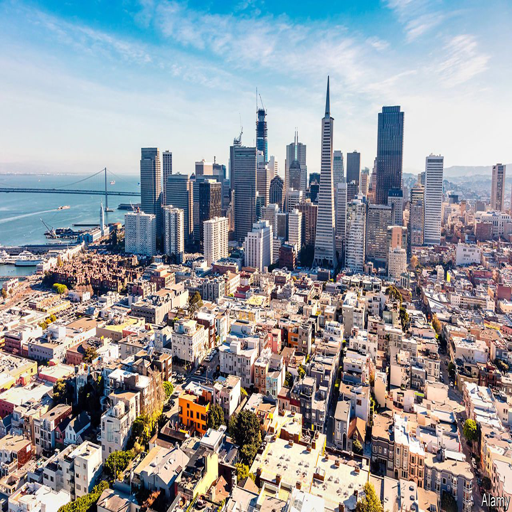

In [62]:
#@title  _content_ image
content_image = open_image(content_url)
content_image = content_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT)) # Resize according to our own hyperparameters
content_image.save(content_image_path)
content_image

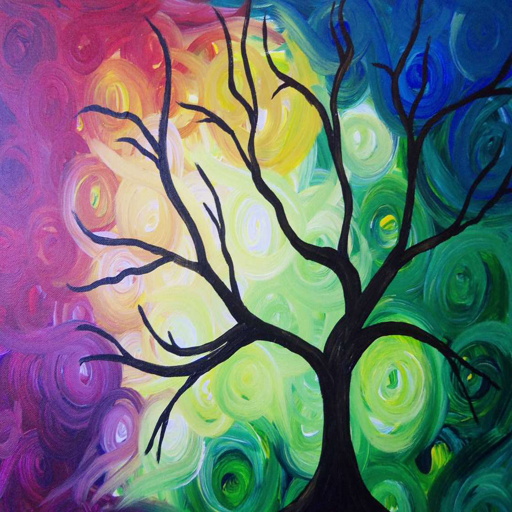

In [63]:
#@title _style_ image
style_image = open_image(style_url)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image.save(style_image_path)
style_image

# Build the algorithm

## Feature loss and total variation

### Feature losses

The feature loss is a loss based on which features a neural network find inside an image. We have two such losses.


In [64]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    # We 'detach' the target content from the tree used
    # to dynamically compute the gradient: this is a stated value,
    # not a variable.
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

The second loss is the style loss. 

In [65]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = self.gram_matrix(target_feature).detach()

  def forward(self, input):
    G = self.gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input

  @staticmethod
  def gram_matrix(input):
    a, b, c, d = input.size()
    # Here:
    # a is the batch size(=1)
    # b is the number of feature maps
    # (c,d) are the dimensions of a feature map

    # We reshape the activation layer into a collection of feature vectors
    features = input.view(a * b, c * d)

    # Compute the gram product
    G = torch.mm(features, features.t())  

    # We 'normalize' the values of the gram matrix
    # by dividing by the norm of gram matrix filled with ones.
    return G.div((a * b * c * d) ** 0.5)

### Total Variation

The last loss is a _smoothing loss_.

In [66]:
def total_variation_loss(x): # Expect a mini batch of dim NxWxH
  image_height = x.shape[1]
  image_width = x.shape[2]
  dx = x[:, :image_height-1, :image_width-1, :] - x[:, 1:, :image_width-1, :]
  dy = x[:, :image_height-1, :image_width-1, :] - x[:, :image_height-1, 1:, :]
  loss = (dx ** 2 + dy ** 2).sum() ** 0.5
  # Return loss normalized by image and batch size
  return loss / (image_width * image_height * x.shape[0])

### Normalization

We add one more block to automatically rescale and remove the mean of the images going through VGG19.

In [67]:
# Function to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # Reshape the mean and std to make them [C x 1 x 1] so that they can
    # directly broadcast to image Tensor of shape [B x C x H x W].
    # B is batch size. C is number of channels. H is height and W is width.
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # Normalize img
    return (img - self.mean) / self.std


#Build VGG19

Using pretrained neural network (VGG19) for computing the losses.

In [68]:
# Neural network used.
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Normalization mean and standard deviation.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

Create a utility function to get model instance and losses( style and content )

In [69]:
def get_model_and_losses(style_img, content_img,
                               cnn=cnn,
                               cnn_normalization_mean=cnn_normalization_mean,
                               cnn_normalization_std=cnn_normalization_std):
  # Make a deep copy of vgg19 in order to not modify the original
  cnn = copy.deepcopy(cnn)
  
  # Normalization module
  normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

  # This list will contain the losses computed by the network.
  content_losses = []
  style_losses = []

  # Rebuild the model as a nn sequential whose first layer is
  # the normalization layer.
  model = nn.Sequential(normalization)

  # stack the layers of 'cnn' model them into `model`.
  i = 0  # Incremented every time we see a conv layer.
  for layer in cnn.children():

    if isinstance(layer, nn.Conv2d):
        i += 1
        name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    # Check if the layer we just added was in the content layer list.
    # If so, we just stack a Content Loss layer.
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_loss_{}".format(i), content_loss)
      content_losses.append(content_loss)

    # Check if the layer we just added was in the style layer list.
    # If so, we just stack a Style Loss layer.
    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)

  # Now we trim off the layers after the last content and style losses
  # to keep the model as small as possible.
  for i in range(len(model) - 1, -1, -1):
      if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
          break

  model = model[:(i + 1)]

  return model, style_losses, content_losses

# Running the algorithm

define functions for converting PIL images to a `torch.Tensor` and apply it to our input images.

In [70]:
def image_to_tensor(image):
  # Transform to tensor
  image = transforms.ToTensor()(image)
  # Fake batch dimension required to fit network's input dimensions
  image = image.unsqueeze(0)
  # Move to the right device and convert to float
  return image.to(device, torch.float)

content_img = image_to_tensor(content_image)
style_img = image_to_tensor(style_image)

Define a inverse function, converting back tensor to images.

In [71]:
# Reconvert a tensor into PIL image
def tensor_to_image(tensor):
  img = (255 * tensor).cpu().detach().squeeze(0).numpy()
  img = img.clip(0, 255).transpose(1, 2, 0).astype("uint8")
  return Image.fromarray(img)

Generate or load the input image from which we are going to converge.

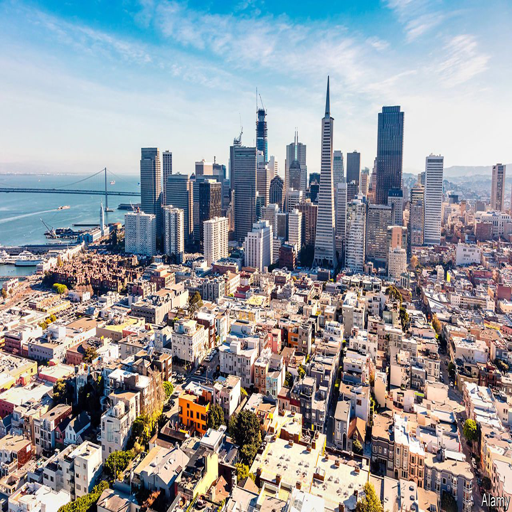

In [72]:
#@title This is the _input_ image
if INPUT_IMAGE == 'noise':
  input_img = torch.randn(content_img.data.size(), device=device)
elif INPUT_IMAGE == 'content':
  input_img = content_img.clone()
elif INPUT_IMAGE == 'style':
  input_img = style_img.clone()
else:
  image = open_image(INPUT_IMAGE).resize((IMAGE_SIZE, IMAGE_SIZE))
  input_img = image_to_tensor(image)
  input_img += torch.randn(content_img.data.size(), device=device)*0.1

# To visualise it better, instead of clipping values, we rescale
# them to fit [-1,1], and convert to an image. This is mostly because
# the visualization given is closer to what the actual values stored
# in the tensor are.
if INPUT_IMAGE == 'noise':
  img = transforms.ToPILImage()(input_img[0].cpu())
else:
  img = tensor_to_image(input_img[0])
img

Using LBFGS optimizer

In [73]:
def get_input_optimizer(input_img):
  # This line tell LBFGS what parameters we should optimize
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  #optimizer = optim.Adam([input_img.requires_grad_()])
  return optimizer

Defining show_evolution function to display the intermediate stages of result image with losses

In [74]:
def show_evolution(tensor, history=[], title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = tensor_to_image(image)
    # Display a big figure
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure()
    # Image
    plt.subplot(121)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    # Losses
    ax = plt.subplot(122)
    plt.yscale('log')
    plt.title('Losses')
    import numpy as np
    history = np.array(history).T
    plt.plot(history[0], label='Style')
    plt.plot(history[1], label='Content')
    plt.plot(history[2], label='Variation')
    plt.plot(history[3], label='Sum')
    plt.legend(loc="upper right")
    # Finaly show the graph
    plt.show()
    # Display a textual message
    print('Style Loss : {:4f} Content Loss: {:4f} Variation Loss: {:4f} Sum: {:4f}'.format(
        history[0][-1], history[1][-1], history[2][-1], history[3][-1]))

Now, building and optimizing the model

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


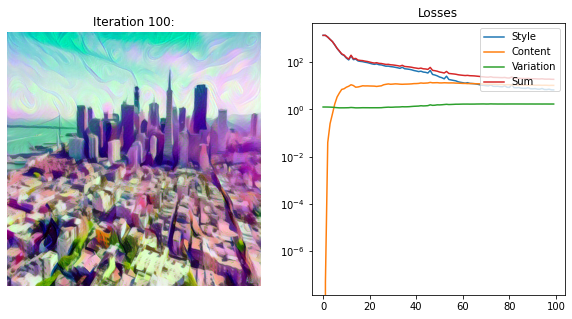

Style Loss : 6.749581 Content Loss: 10.476613 Variation Loss: 1.700348 Sum: 18.926542


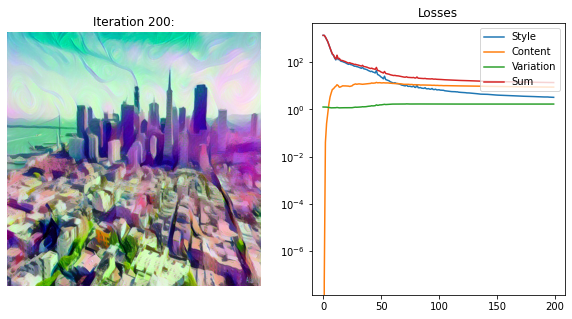

Style Loss : 3.265784 Content Loss: 8.852141 Variation Loss: 1.695707 Sum: 13.813633


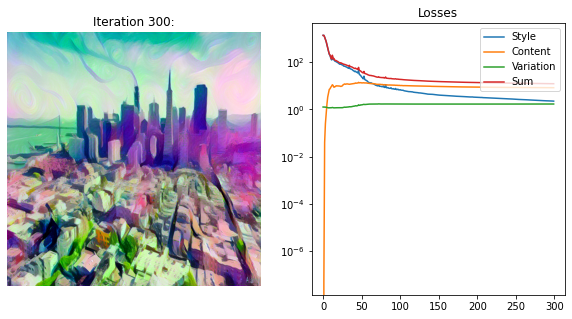

Style Loss : 2.249854 Content Loss: 8.363958 Variation Loss: 1.702561 Sum: 12.316374


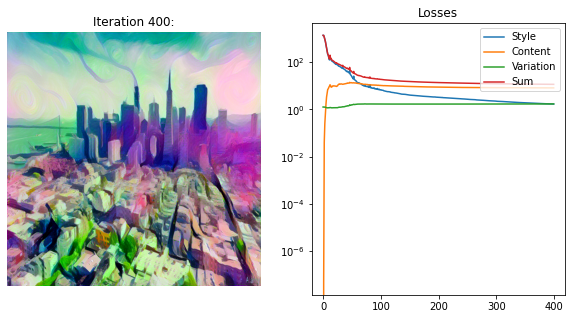

Style Loss : 1.698654 Content Loss: 8.204803 Variation Loss: 1.716353 Sum: 11.619808


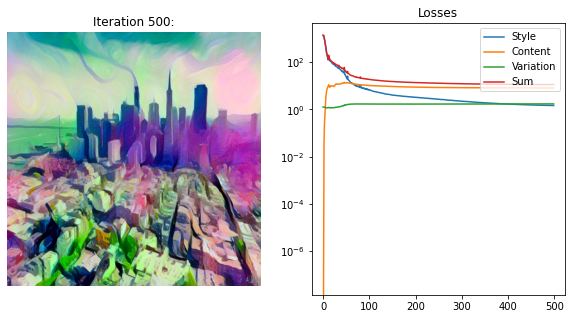

Style Loss : 1.470320 Content Loss: 8.092171 Variation Loss: 1.722645 Sum: 11.285135


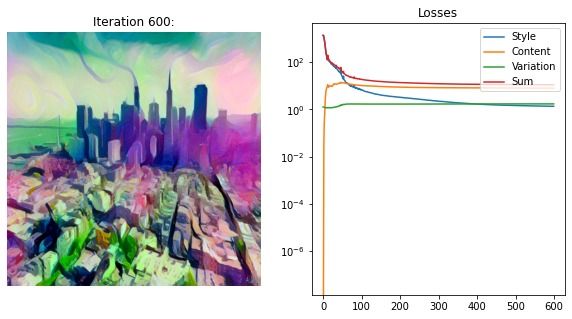

Style Loss : 1.365104 Content Loss: 8.001995 Variation Loss: 1.721391 Sum: 11.088490


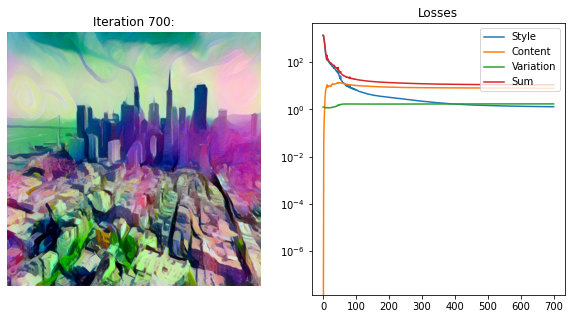

Style Loss : 1.305854 Content Loss: 7.937978 Variation Loss: 1.721036 Sum: 10.964869


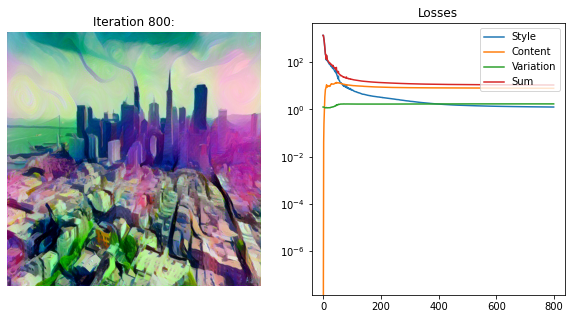

Style Loss : 1.267437 Content Loss: 7.889463 Variation Loss: 1.722221 Sum: 10.879122


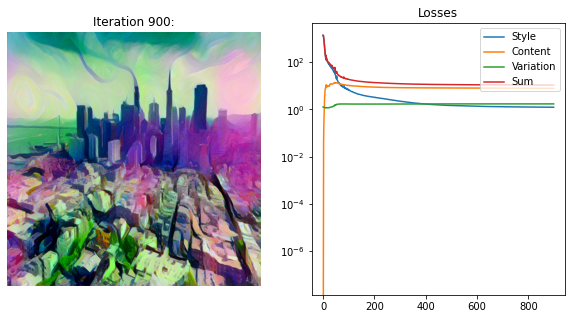

Style Loss : 1.241432 Content Loss: 7.853545 Variation Loss: 1.723340 Sum: 10.818317


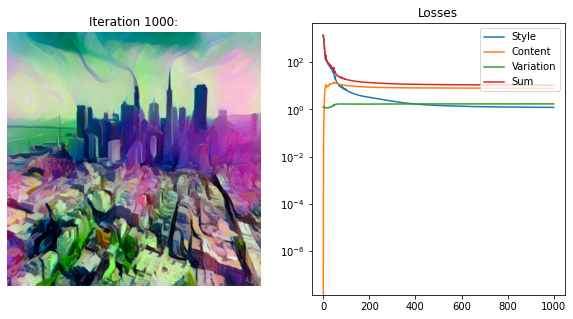

Style Loss : 1.226324 Content Loss: 7.832345 Variation Loss: 1.723392 Sum: 10.782062


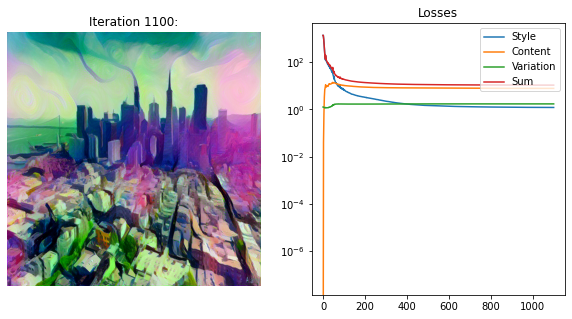

Style Loss : 1.217241 Content Loss: 7.819747 Variation Loss: 1.722882 Sum: 10.759870


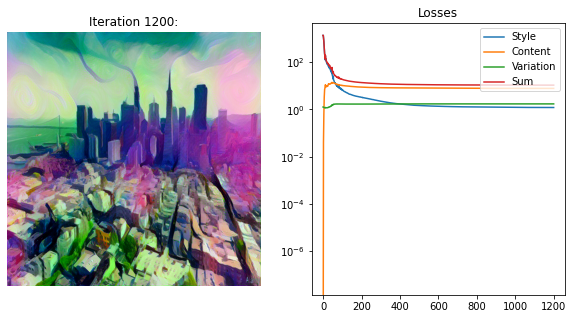

Style Loss : 1.211905 Content Loss: 7.810791 Variation Loss: 1.722204 Sum: 10.744900


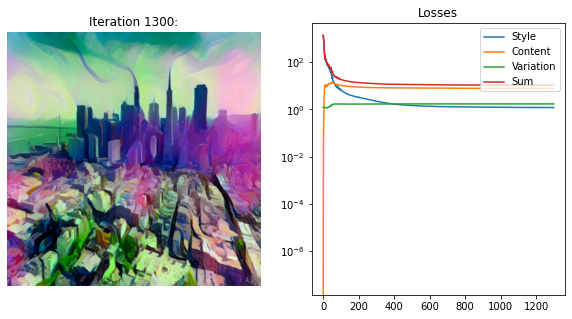

Style Loss : 1.207653 Content Loss: 7.804962 Variation Loss: 1.721555 Sum: 10.734170


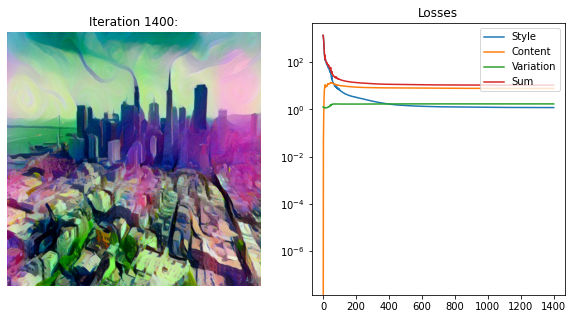

Style Loss : 1.204071 Content Loss: 7.801084 Variation Loss: 1.720945 Sum: 10.726099


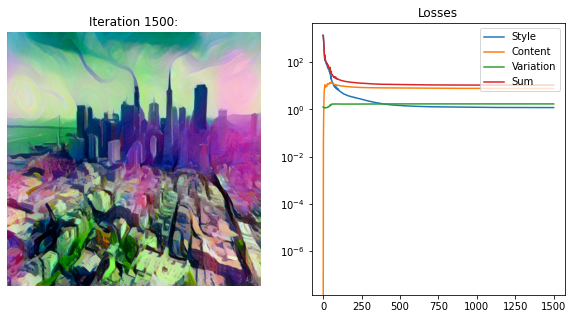

Style Loss : 1.201715 Content Loss: 7.797589 Variation Loss: 1.720432 Sum: 10.719737


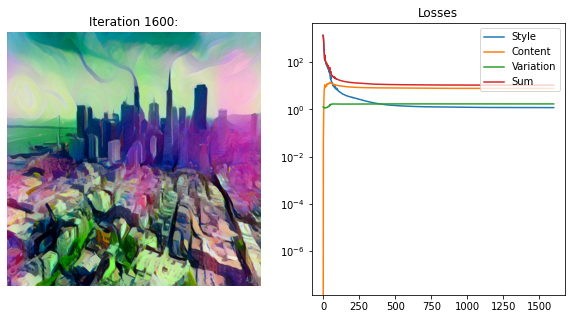

Style Loss : 1.199594 Content Loss: 7.794781 Variation Loss: 1.719975 Sum: 10.714349


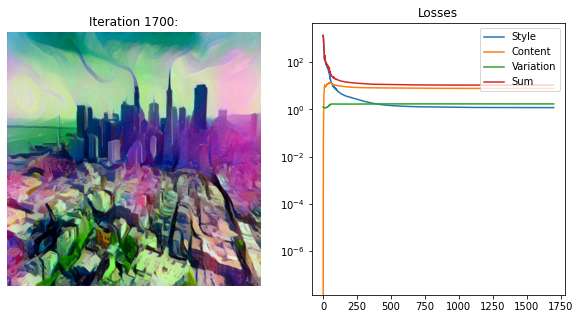

Style Loss : 1.197827 Content Loss: 7.792394 Variation Loss: 1.719570 Sum: 10.709791


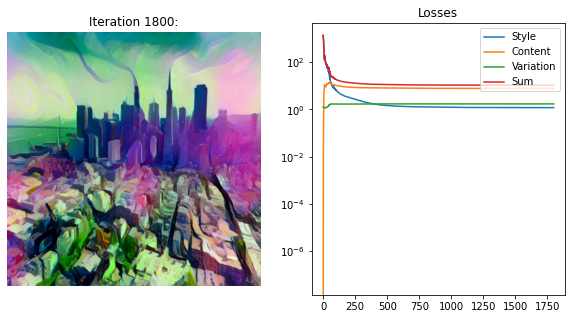

Style Loss : 1.196319 Content Loss: 7.790314 Variation Loss: 1.719236 Sum: 10.705869


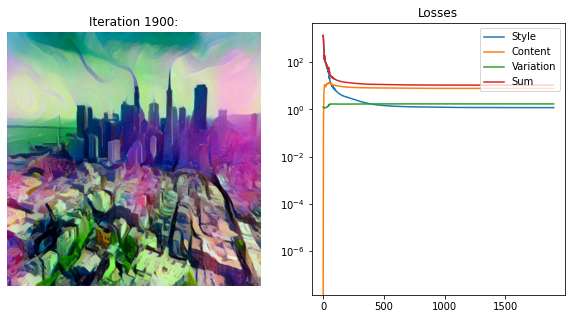

Style Loss : 1.194955 Content Loss: 7.788597 Variation Loss: 1.718927 Sum: 10.702479


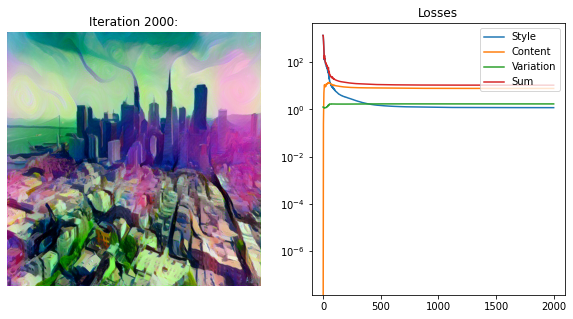

Style Loss : 1.193761 Content Loss: 7.787131 Variation Loss: 1.718659 Sum: 10.699552


In [75]:
print('Building the style transfer model..')
model, style_losses, content_losses = get_model_and_losses(style_img, content_img)
optimizer = get_input_optimizer(input_img)

print('Optimizing..')
iterations = 0
history=[]
while iterations <= ITERATIONS * 100:
  # Compute the loss and backpropagate to the input_image.
  # (The LBFGS optimizer only accept work through closures.)
  def closure():
      global history
      global iterations
      
      optimizer.zero_grad()
      
      # Compute the total variation loss
      variation_score = total_variation_loss(input_img) * TOTAL_VARIATION_WEIGHT
      # Compute the features through the model
      model(input_img)
      # Compute style and content losses
      style_score = sum(sl.loss for sl in style_losses)
      style_score *= STYLE_WEIGHT / len(style_losses)
      content_score = sum(cl.loss for cl in content_losses)
      content_score *= CONTENT_WEIGHT / len(content_losses)
      # Our global loss is the sum of the 3 values
      loss = style_score + content_score + variation_score
      # Save the value of loss in order to draw them as a graph
      history += [[style_score.item(), content_score.item(), variation_score.item(), loss.item()]]

      # If the iteration is a multiple of 100, display some informations
      iterations += 1
      if iterations % 100 == 0:
          show_evolution(input_img.data.clone().detach().clamp(0, 1), history, title="Iteration %d:" % iterations)
      
      # Backpropagate gradients and leave the optimizer do his job.
      loss.backward()
      return loss

  optimizer.step(closure)


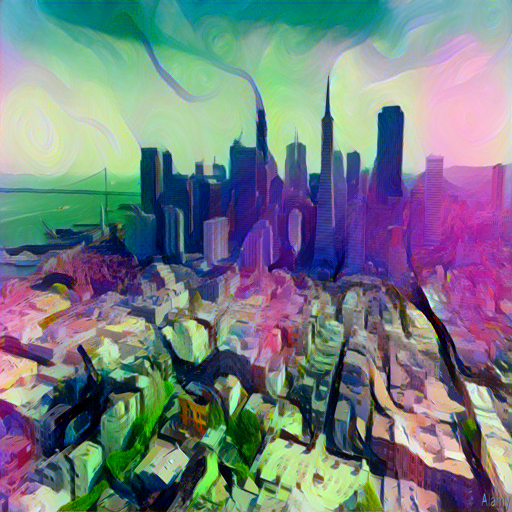

In [76]:
#@title Transferred Image
img = tensor_to_image(input_img);img.save(output_image_path)
img

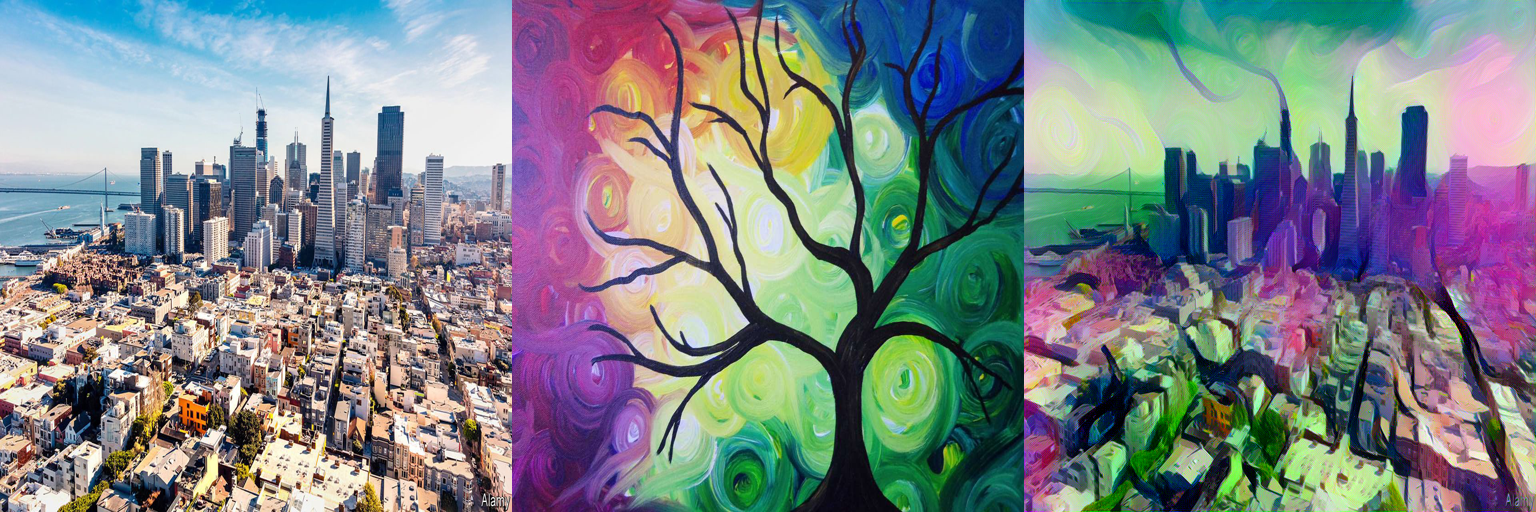

In [77]:
#@title Final Results
combined = Image.new("RGB", (IMAGE_WIDTH*3, IMAGE_HEIGHT))
x_offset = 0
for image in map(Image.open, [content_image_path, style_image_path, output_image_path]):
    combined.paste(image, (x_offset, 0))
    x_offset += IMAGE_WIDTH
combined.save('combined.png')
combined